# Time-series inversion - Demo
### Introduction
This notebook walks through the steps necessary to obtain a continuous displacement time series through the inversion of a network of pairwise cross-correlation results from (optical) satellite imagery. As a prerequisite to running this notebook, the user must obtain these pairwise displacement measurements. The code of this repository is adapted for image correlation results from the Ames Stereo Pipeline, but also other correlators may be used. A repository that provides a wrapper around [Ames Stereo Pipeline](https://github.com/NeoGeographyToolkit/StereoPipeline) functionalities to obtain displacement fields from PlanetScope data can be found [here](https://github.com/UP-RS-ESP/PlanetScope_landslide_tracking). 
For this demo, we have provided a network of 25 displacement maps at 10 m resolution obtained from Sentinel-2 data over the Del Medio landslide in northwestern Argentina. These are stored in the folder [demo_data](./demo_data). 
Lets have a look at these files: 

In [1]:
import glob
import os
import pandas as pd
import timeseries_inversion as tsi
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

files = glob.glob('./demo_data/*-F.tif') #-F for filtered disparity map
files.sort()
for f in files:
    print(os.path.basename(f))

20200415T142729_20210520T142729-F.tif
20200415T142729_20211017T142729-F.tif
20200415T142729_20220714T142719-F.tif
20200415T142729_20241011T142709-F.tif
20200803T142739_20220714T142719-F.tif
20200803T142739_20220912T142719-F.tif
20200803T142739_20230619T142719-F.tif
20201101T142739_20230619T142719-F.tif
20201101T142739_20240504T142719-F.tif
20201101T142739_20241011T142709-F.tif
20210520T142729_20240504T142719-F.tif
20210629T142729_20231106T142719-F.tif
20210629T142729_20240504T142719-F.tif
20210629T142729_20240812T142719-F.tif
20210818T142729_20231106T142719-F.tif
20210818T142729_20240812T142719-F.tif
20211017T142729_20221101T142709-F.tif
20211017T142729_20230619T142719-F.tif
20211017T142729_20240812T142719-F.tif
20220714T142719_20241011T142709-F.tif
20220912T142719_20230619T142719-F.tif
20221101T142709_20231106T142719-F.tif
20230619T142719_20240504T142719-F.tif
20231106T142719_20240812T142719-F.tif
20231106T142719_20241011T142709-F.tif


Filenames contain the acquisition dates of the reference and secondary image. Knowing these dates is essential to sensibly construct the network. The file itself contains 3 bands which store the displacement in east-west (band 1) and north-south (band 2) displacement in pixels. Band 3 is the good pixel mask.
The acquisition pairs from the filename can be used to assess the network structure:

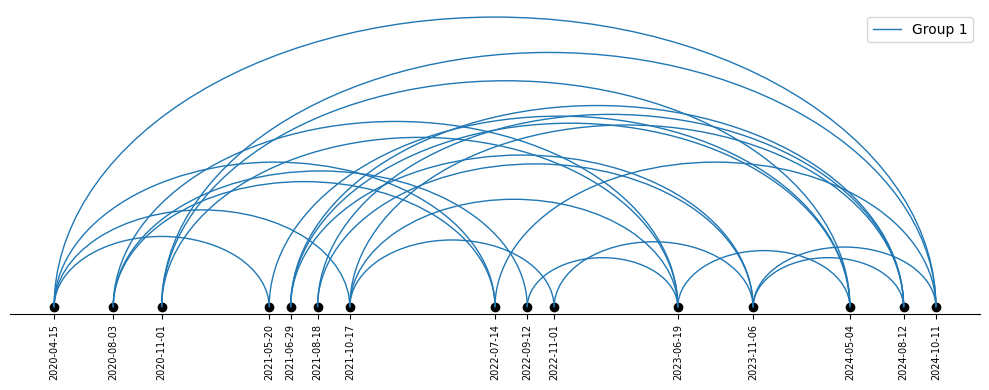

In [2]:
network = pd.DataFrame({'date0':[os.path.basename(f).split('_')[0][0:8] for f in files], 
                        'date1':[os.path.basename(f).split('_')[1][0:8] for f in files]})

network.date0 = pd.to_datetime(network.date0)
network.date1 = pd.to_datetime(network.date1)

tsi.plot_network(network)

We can see that we have a connected network covering the period between 2020 and 2024. The network dataframe that we have constructed will be the input to our inversion process, but before we can run it, we have to consider a potential constraint: our RAM. Our exemplary network is quite lightweight, but in reality, the displacement fields may have a larger extent, higher spatial resolution and our network more connections. Loading all these data into memory is not feasible, therefore we will process the displacement maps on a tile bases. The function will also take care of converting the displacement in units of pixels to meter (easier to work with), apply the good pixel mask (3 bands -> 2 bands) and perform a median shift to center all displacement at 0. For the median shift, we should supply a landslide mask to exclude unstable pixels. You can find such a mask in the demo_data folder as well. Finally, the function will also check if all displacement fields have the same size which is a prerequisite for the inversion. If this is not the case (may happen for imagery with a small footprint not covering the enitre AOI), the largest image will be selected and all smaller displacement fields will be padded with nan to get to a common size. 

In [3]:
lsmask = './demo_data/landslide_mask.tif'
files_tiled = tsi.pre_process_for_inversion(files, blocksize = 256, pix_to_m = True, medshift = True, overwrite = True, unstable_mask = lsmask)

Interpreting and applying band 3 as good pixel mask.
I have written ./demo_data/20200415T142729_20210520T142729-F_medshift_in_m_tiled.tif.
Interpreting and applying band 3 as good pixel mask.
I have written ./demo_data/20200415T142729_20211017T142729-F_medshift_in_m_tiled.tif.
Interpreting and applying band 3 as good pixel mask.
I have written ./demo_data/20200415T142729_20220714T142719-F_medshift_in_m_tiled.tif.
Interpreting and applying band 3 as good pixel mask.
I have written ./demo_data/20200415T142729_20241011T142709-F_medshift_in_m_tiled.tif.
Interpreting and applying band 3 as good pixel mask.
I have written ./demo_data/20200803T142739_20220714T142719-F_medshift_in_m_tiled.tif.
Interpreting and applying band 3 as good pixel mask.
I have written ./demo_data/20200803T142739_20220912T142719-F_medshift_in_m_tiled.tif.
Interpreting and applying band 3 as good pixel mask.
I have written ./demo_data/20200803T142739_20230619T142719-F_medshift_in_m_tiled.tif.
Interpreting and applying b

## Time-series inversion
The tiled displacement fields can now finally be passed to the inversion process which will run the time-series inversion pixelwise for each tile in the provided displacement fields. The tiled inversion expects a network dataframe as input which specifies the names of the relevant input files. Therefore, make sure to add a filename column with the tiled displacement fields. We also need to select the displacement component – as the landslide dips eastward, let’s choose the east-west component (band 1). For moving surfaces that are not purely east-west or north-south striking, run the inversion separately for both displacement components and use the resulting displacement to calculate velocity and displacement direction.
Running the inversion may take a moment. 

In [4]:
network['filename'] = files_tiled #specify files to be used

tsi.inversion_tiled(network, band = 1, cpu = 8)

100%|█████████████████████████████████████████████| 6/6 [02:29<00:00, 24.98s/it]


The inversion generates a new raster called inversion_dx.tif, stored in the [inversion_out](./inversion_out) folder. This is a multiband raster that stores the cumulative displacement estimated for each unique date in the network. We can visualize the results for every timestep: 

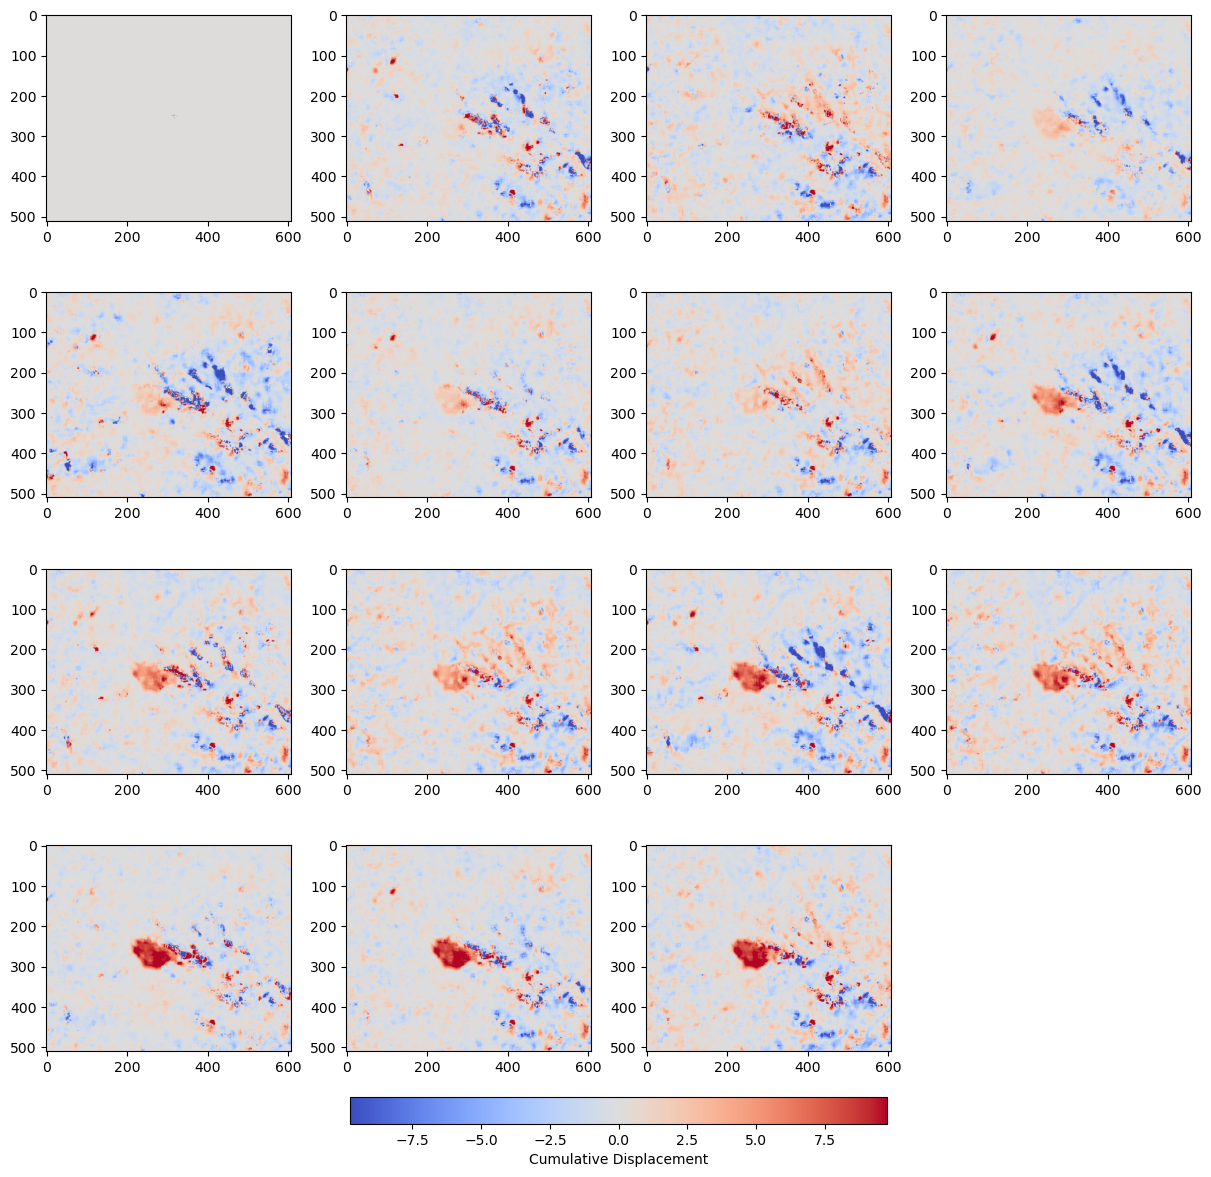

In [5]:
tsi.plot_timesteps("./inversion_out/inversion_dx.tif")

The landslide is well visible. We can again use the landslide mask to extract statistics over the unstable surface.

In [6]:
stats = tsi.extract_stats_in_mask('./inversion_out/inversion_dx.tif', lsmask)
print(stats)

      median       p25       p75      mean       std
0   0.000000  0.000000  0.000000  0.000000  0.000000
1   0.522191 -2.991915 -2.062926  0.686834  1.193994
2  -0.256979 -4.976569 -3.133082 -0.280322  1.124952
3   2.117664 -1.785330 -0.558672  2.131924  1.016040
4   2.074058 -5.821921 -2.065749  2.239545  1.872797
5   1.900280 -3.919819 -1.526555  1.988689  1.466294
6   1.557202 -2.265930 -1.244568  1.630706  1.240677
7   4.817016 -0.921496 -0.375054  4.820600  1.920116
8   4.661487 -1.008833 -0.319170  4.586277  1.980412
9   3.819440 -1.484869 -0.472863  3.844800  1.902671
10  6.662837 -3.483149 -0.898008  6.317299  2.518035
11  5.668040 -1.639613 -0.178650  5.632387  2.308398
12  8.494499 -1.803621 -0.870907  8.223511  3.038339
13  8.287889 -1.444606 -0.552245  7.961991  2.928675
14  8.430279 -1.931323 -1.029901  8.074926  3.080245


The resulting data frame contains the statistics for each time step for the provided mask. These timesteps relate to the unique dates in our network. When getting all unique dates, we can plot a time series:

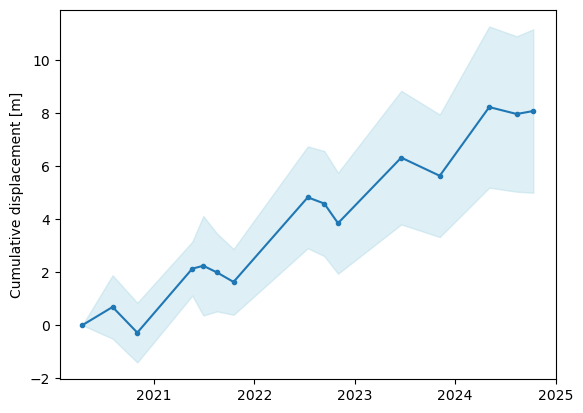

In [7]:
dates = pd.concat([network["date0"], network["date1"]]).unique()
dates = np.sort(dates)

plt.figure()
plt.fill_between(dates, stats["mean"]-stats["std"], stats["mean"]+stats["std"], color="lightblue", alpha=0.4,) 
plt.plot(dates, stats['mean'], marker = '.')
plt.ylabel('Cumulative displacement [m]')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())

### Seasonal bias estimation
It is slightly visible in the time series above and becomes even more obvious with the addition of more timesteps: the displacement time series is characterized by an oscillation pattern that is linked to systematic measurement errors in cross-season pairs with different illumination. The magnitude of this bias can be approximated with a sine function that has a fixes one-year frequency. 
In the following, we fit a sine function to the detrended cumulative displacement time series of each pixel. This will again take a moment to compute.  

In [8]:
tsi.fit_sine_tiled('./inversion_out/inversion_dx.tif', dates, cpu = 8)

100%|█████████████████████████████████████████████| 6/6 [07:27<00:00, 74.59s/it]


The output of this process is a 3-band GeoTIFF that contains the estimated amplitude, phase (in degrees), and vertical offset of the sine fit per pixel, called [inversion_dx_sine_fit.tif](./inversion_out/inversion_dx_sine_fit.tif), stored in the same folder as the inversion output. We can visualize the results: 

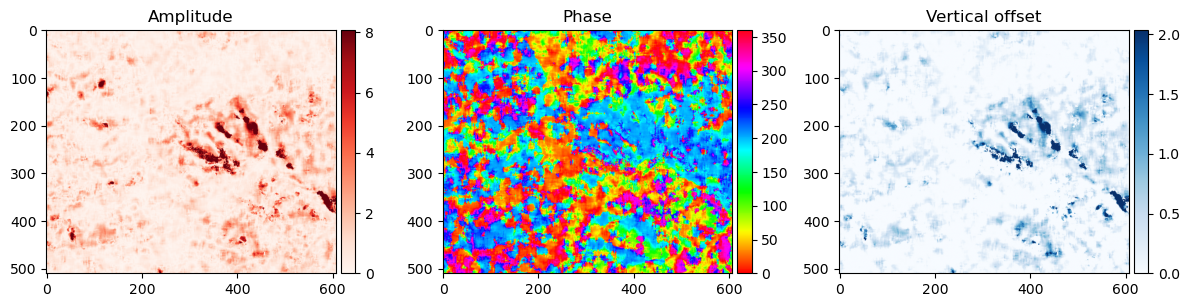

In [9]:
tsi.plot_sine_fit('./inversion_out/inversion_dx_sine_fit.tif')

We can not only estimate a fixed-frequency sine wave per pixel, it can also be applied to remove seasonal oscillations from the displacement time series. When the fit parameters are already estimated (as we did in the previous step), these can be directly used to perform the correction. Else the function would estimate the fit again. 

In [10]:
tsi.apply_sine_tiled('./inversion_out/inversion_dx.tif', dates, cpu = 8, fit_file = './inversion_out/inversion_dx_sine_fit.tif')

100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.17s/it]


If the fit parameters are already estimated, the removal of the best-fit sine per pixel is relatively fast. The output is stored under [./inversion_out/inversion_dx_sine_corrected.tif](inversion_out/inversion_dx_sine_corrected.tif). When we plot the individual time steps again, we can see that the displacement estimated over stable terran (measurement error) has reduced. There are still errors remaining particularly in shadowed areas where the residual to the estimated fit is high. 

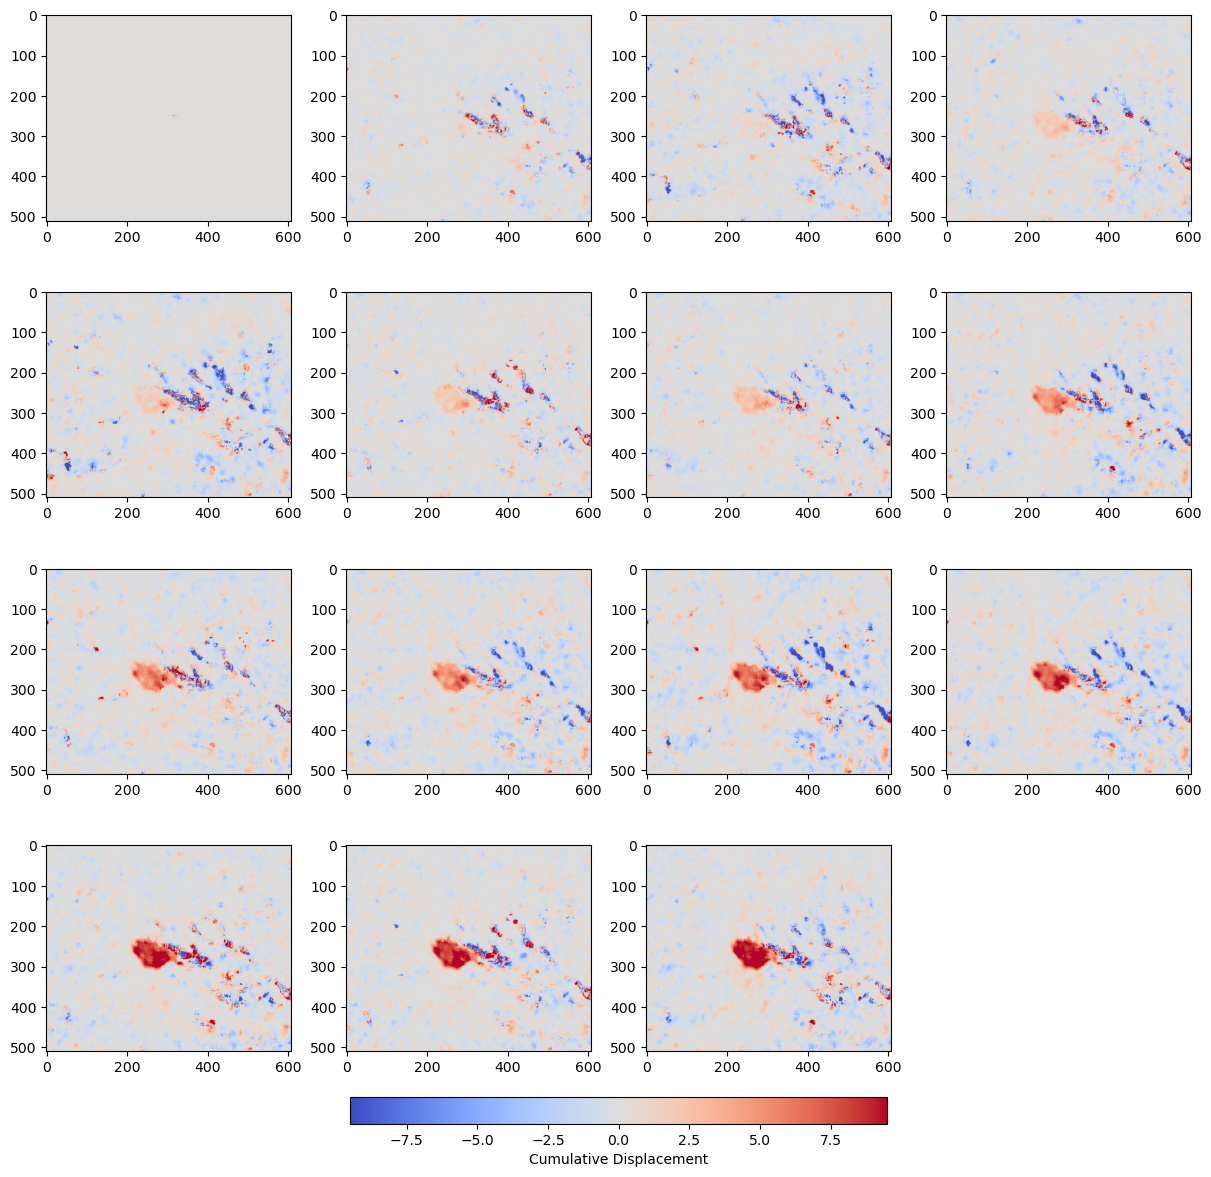

In [13]:
tsi.plot_timesteps("./inversion_out/inversion_dx_sine_corrected.tif")

Over the landslide, where the seasonal oscillations are quite regular, the cumulative displacement time series after correction looks as follows: 

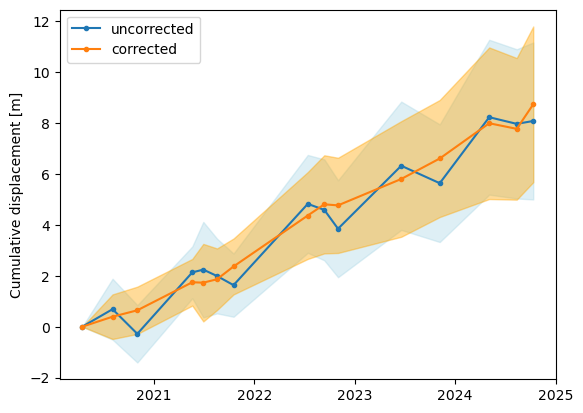

In [17]:
stats_corrected = tsi.extract_stats_in_mask('./inversion_out/inversion_dx_sine_corrected.tif', lsmask)

plt.figure()
plt.fill_between(dates, stats["mean"]-stats["std"], stats["mean"]+stats["std"], color="lightblue", alpha=0.4,) 
plt.fill_between(dates, stats_corrected["mean"]-stats_corrected["std"], stats_corrected["mean"]+stats_corrected["std"], color="orange", alpha=0.4,) 
plt.plot(dates, stats['mean'], marker = '.', label = 'uncorrected')
plt.plot(dates, stats_corrected['mean'], marker = '.', label = 'corrected')
plt.ylabel('Cumulative displacement [m]')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())